## 计算机视觉：图像分类

### 项目介绍：基于Analytics-Zoo Orca on yarn 分布式框架训练图像分类模型
### 1.导入模块，初始化运行环境

In [1]:
import tensorflow as tf
from zoo.orca import init_orca_context, stop_orca_context
from zoo.orca.learn.tf2 import Estimator
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

/root/anaconda3/envs/zoo-tf2.3/lib/python3.6/site-packages/bigdl/util/engine.py:41: UserWarning: Find both SPARK_HOME and pyspark. You may need to check whether they match with each other. SPARK_HOME environment variable is set to: /usr/local/spark2, and pyspark is found in: /root/anaconda3/envs/zoo-tf2.3/lib/python3.6/site-packages/pyspark/__init__.py. If they are unmatched, please use one source only to avoid conflict. For example, you can unset SPARK_HOME and use pyspark only.
  warnings.warn(warning_msg)
/root/anaconda3/envs/zoo-tf2.3/lib/python3.6/site-packages/zoo/util/engine.py:42: UserWarning: Find both SPARK_HOME and pyspark. You may need to check whether they match with each other. SPARK_HOME environment variable is set to: /usr/local/spark2, and pyspark is found in: /root/anaconda3/envs/zoo-tf2.3/lib/python3.6/site-packages/pyspark/__init__.py. If they are unmatched, you are recommended to use one source only to avoid conflict. For example, you can unset SPARK_HOME and use p

Prepending /root/anaconda3/envs/zoo-tf2.3/lib/python3.6/site-packages/bigdl/share/conf/spark-bigdl.conf to sys.path
Adding /root/anaconda3/envs/zoo-tf2.3/lib/python3.6/site-packages/zoo/share/lib/analytics-zoo-bigdl_0.12.1-spark_2.4.3-0.9.0-SNAPSHOT-jar-with-dependencies.jar to BIGDL_JARS
Prepending /root/anaconda3/envs/zoo-tf2.3/lib/python3.6/site-packages/zoo/share/conf/spark-analytics-zoo.conf to sys.path


In [2]:
## 查看系统的环境变量
import os
print(os.environ["PATH"])

/root/anaconda3/envs/zoo-tf2.3/bin:/root/anaconda3/bin:/root/anaconda3/bin:/usr/jdk64/java/bin:/usr/hdp/3.0.1.0-187/hadoop/bin:/usr/local/spark2/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin


### 2.载入cifar10数据集

In [3]:
# cifar10类别名字
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
# cifar10 图像数据大小
image_shape = (32, 32, 3)
# TFrecord example定义
image_feature_description = {
    'height': tf.io.FixedLenFeature([], tf.int64),
    'width': tf.io.FixedLenFeature([], tf.int64),
    'label': tf.io.FixedLenFeature([], tf.int64),
    'image_raw': tf.io.FixedLenFeature([], tf.string),
}


def _parse_image_function(example_proto):
    # Parse the input tf.Example proto using the dictionary above.
    image_features = tf.io.parse_single_example(example_proto, image_feature_description)
    image = tf.io.decode_raw(image_features['image_raw'], tf.uint8)
    img_h = image_features['height']
    img_w = image_features['width']
    image = tf.reshape(image, (img_h, img_w, -1))
    lable = image_features['label']
    return image, lable

# 定义读取TFRecord数据
filename = "hdfs://manager:8020/zoo-datasets/cifar10_valid.tfrecord"
dataset = tf.data.TFRecordDataset(filename)
dataset = dataset.map(_parse_image_function)

### 3.数据分析
#### 3.1原始数据可视化

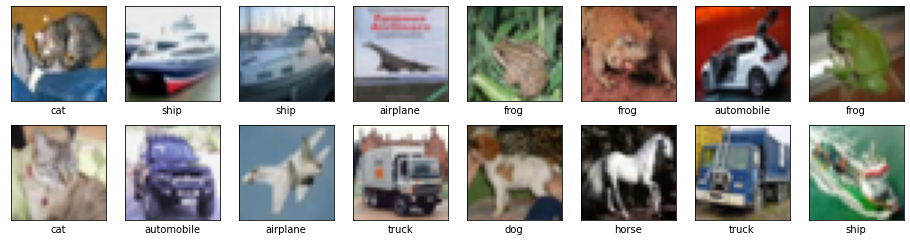

In [4]:
iter_dataset = dataset.as_numpy_iterator()
plt.figure(figsize=(16,4))
for i in range(16):
    plt.subplot(2,8,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    image, label = iter_dataset.next()
    plt.imshow(image, cmap=plt.cm.binary)
    plt.xlabel(class_names[int(label)])
plt.show()

#### 3.2数据增广以及可视化

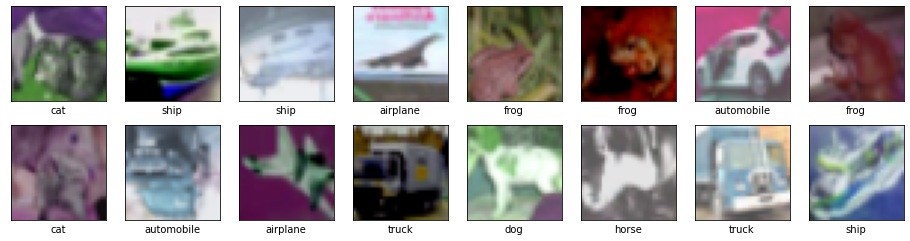

In [5]:
def preprocess_image(image, label):
    #Color augmentation
    x = tf.image.random_hue(image, 0.3)
    x = tf.image.random_saturation(x, 0.6, 1.6)
    x = tf.image.random_brightness(x, 0.3)
    x = tf.image.random_contrast(x, 0.7, 1.3)
    #Flip
    x = tf.image.random_flip_left_right(x)
    x = tf.image.random_flip_up_down(x)
    #Random crop
    x = tf.image.random_crop(x,size=[int(image_shape[0] * 0.9), int(image_shape[1] * 0.9), 3])
    x = tf.image.resize(x, [image_shape[0], image_shape[1]])
    return x, label
preprocess_dataset = dataset.map(preprocess_image)
iter_dataset = preprocess_dataset.as_numpy_iterator()
plt.figure(figsize=(16,4))
for i in range(16):
    plt.subplot(2,8,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    image, label = iter_dataset.next()
    image = image.astype(np.uint8)
    plt.imshow(image, cmap=plt.cm.binary)
    plt.xlabel(class_names[int(label)])
plt.show()

In [6]:
# 自定义方式增广
from imgaug import augmenters as iaa
seq = iaa.Sequential([
            iaa.Fliplr(0.5),
            iaa.Affine(translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
                       shear={"x": (-1, 1), "y": (-1, 1)},
                       scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
                       rotate=(-10, 10)
                       ),
            iaa.MultiplyAndAddToBrightness(mul=(0.5, 1.5), add=(-30, 30), from_colorspace="RGB"),
            iaa.MultiplyHueAndSaturation(mul_hue=(0.5, 1.5)),
            iaa.Resize({"height": 32, "width": 32})
        ])

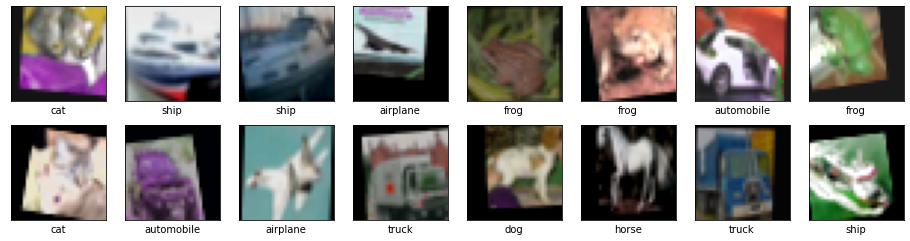

In [7]:
def image_aug(image):
    result = seq(image=image.numpy())
    return result
def preprocess_image(x, y):
    x = tf.py_function(image_aug, [x], tf.float32)
    return x, y

preprocess_dataset = dataset.map(preprocess_image, num_parallel_calls=2)
iter_dataset = preprocess_dataset.as_numpy_iterator()
plt.figure(figsize=(16,4))
for i in range(16):
    plt.subplot(2,8,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    image, label = iter_dataset.next()
    image = image.astype(np.uint8)
    plt.imshow(image, cmap=plt.cm.binary)
    plt.xlabel(class_names[int(label)])
plt.show()

### 4.构建数据预处理Pipeline

In [8]:
# 指定cifar10 TFRecord hdfs保存路径
train_path = "hdfs://manager:8020/zoo-datasets/cifar10_train.tfrecord"
valid_path = "hdfs://manager:8020/zoo-datasets/cifar10_valid.tfrecord"

In [9]:
def train_preprocess(image, label):
    #Color augmentation
    x = tf.image.random_hue(image, 0.3)
    x = tf.image.random_saturation(x, 0.6, 1.6)
    x = tf.image.random_brightness(x, 0.3)
    x = tf.image.random_contrast(x, 0.7, 1.3)
    #Flip
    x = tf.image.random_flip_left_right(x)
    x = tf.image.random_flip_up_down(x)
    #Random crop
    x = tf.image.random_crop(x,size=[int(image_shape[0] * 0.9), int(image_shape[1] * 0.9), 3])
    x = tf.image.resize(x, [image_shape[0], image_shape[1]])
    return x, label
def image_aug(image):
    result = seq(image=image.numpy())
    return result
def train_preprocess_aug(x, y):
    x = tf.py_function(image_aug, [x], tf.float32)
    x = tf.cast(tf.reshape(x, (image_shape)), dtype=tf.float32) / 255.0
    return x, y

def test_preprocess(x, y):
    x = tf.cast(tf.reshape(x, image_shape), dtype=tf.float32) / 255.0
    return x, y

def train_data_creator(config):
    dataset = tf.data.TFRecordDataset(train_path)
    dataset = dataset.repeat()
    dataset = dataset.map(_parse_image_function)
    dataset = dataset.map(test_preprocess)
    dataset = dataset.shuffle(1000)
    dataset = dataset.batch(config["batch_size"])

    return dataset


def val_data_creator(config):
    dataset = tf.data.TFRecordDataset(valid_path)
    dataset = dataset.repeat()
    dataset = dataset.map(_parse_image_function)
    dataset = dataset.map(test_preprocess)
    dataset = dataset.batch(config["batch_size"])

    return dataset

### 5.构建模型算法

In [10]:
def model_creator(config):
    model = tf.keras.Sequential(
        [tf.keras.layers.Conv2D(32, kernel_size=(3, 3), strides=(1, 1), activation='relu',
                                input_shape=image_shape, padding='same'),
         tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'),
         tf.keras.layers.Conv2D(64, kernel_size=(3, 3), strides=(1, 1), activation='relu',
                                padding='valid'),
         tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'),
         tf.keras.layers.Conv2D(64, kernel_size=(3, 3), strides=(1, 1), activation='relu',
                                padding='valid'),
         tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'),
         tf.keras.layers.Flatten(),
         tf.keras.layers.Dense(500, activation='relu'),
         tf.keras.layers.Dense(256, activation='relu'),
         tf.keras.layers.Dense(84, activation='relu'),
         tf.keras.layers.Dense(10, activation='softmax'),
         ]
    )


    model.compile(optimizer=tf.keras.optimizers.RMSprop(),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [11]:
batch_size = 320
config = dict(batch_size=batch_size)
model = model_creator(config)
train_dataset = train_data_creator(config)
valid_dataset = val_data_creator(config)
model.fit(train_dataset, epochs= 10, steps_per_epoch=50000 // batch_size,
                     validation_data=valid_dataset, validation_steps=10000 // batch_size)

Epoch 1/10
156/156 [==============================] - 22s 138ms/step - loss: 2.0074 - accuracy: 0.2692 - val_loss: 1.7203 - val_accuracy: 0.3871
Epoch 2/10
156/156 [==============================] - 21s 135ms/step - loss: 1.6611 - accuracy: 0.4023 - val_loss: 1.4989 - val_accuracy: 0.4736
Epoch 3/10
156/156 [==============================] - 21s 134ms/step - loss: 1.4524 - accuracy: 0.4782 - val_loss: 1.6497 - val_accuracy: 0.4334
Epoch 4/10
156/156 [==============================] - 21s 133ms/step - loss: 1.3166 - accuracy: 0.5331 - val_loss: 1.2388 - val_accuracy: 0.5564
Epoch 5/10
156/156 [==============================] - 21s 132ms/step - loss: 1.2190 - accuracy: 0.5685 - val_loss: 1.2995 - val_accuracy: 0.5309
Epoch 6/10
156/156 [==============================] - 21s 134ms/step - loss: 1.1289 - accuracy: 0.6010 - val_loss: 1.1548 - val_accuracy: 0.5964
Epoch 7/10
156/156 [==============================] - 21s 135ms/step - loss: 1.0547 - accuracy: 0.6287 - val_loss: 1.1273 - val_ac

### 6.定义整个训练函数

In [12]:
def main(max_epoch):
    batch_size = 320
    config = {
        "batch_size": batch_size
    }

    est = Estimator.from_keras(model_creator, config=config, workers_per_node=2)

    history = est.fit(train_data_creator,
                    epochs=max_epoch,
                    steps_per_epoch=50000 // batch_size,
                    validation_data_creator=val_data_creator,
                    validation_steps=10000 // batch_size
                     )
    print(history)
    est.save("/tmp/cifar10_keras.ckpt")
    est.restore("/tmp/cifar10_keras.ckpt")
    stats = est.evaluate(val_data_creator, steps=10000 // batch_size)
    print(stats)
    return history

### 7.基于Orca on yarn模式训练模型

In [13]:
cluster_mode = "yarn"
if cluster_mode == "local":
    init_orca_context(cluster_mode="local", cores=4, init_ray_on_spark=True)
elif cluster_mode == "yarn":
    init_orca_context(cluster_mode="yarn-client", num_nodes=2, cores=2,
                      init_ray_on_spark=True, memory="6g", driver_memory="6g",hadoop_user_name='hdfs', hadoop_conf="/etc/hadoop/3.0.1.0-187/0/")

history = main(5)

Initializing orca context
Current pyspark location is : /root/anaconda3/envs/zoo-tf2.3/lib/python3.6/site-packages/pyspark/__init__.py
Initializing SparkContext for yarn-client mode
Start to pack current python env
Packing has been completed: /tmp/tmp1sp3eqoq/python_env.tar.gz
pyspark_submit_args is: --master yarn --deploy-mode client --archives /tmp/tmp1sp3eqoq/python_env.tar.gz#python_env --driver-cores 4 --driver-memory 6g --num-executors 2 --executor-cores 2 --executor-memory 6g --driver-class-path /root/anaconda3/envs/zoo-tf2.3/lib/python3.6/site-packages/zoo/share/lib/analytics-zoo-bigdl_0.12.1-spark_2.4.3-0.9.0-SNAPSHOT-jar-with-dependencies.jar:/root/anaconda3/envs/zoo-tf2.3/lib/python3.6/site-packages/bigdl/share/lib/bigdl-0.12.1-jar-with-dependencies.jar pyspark-shell
JavaGatewayServer has been successfully launched on executors
Start to launch ray on cluster
Start to launch ray driver on local
Executing command: ray start --address 10.180.210.172:64144 --redis-password 12345

2020-12-16 09:06:54,511	WARNING worker.py:792 -- When connecting to an existing cluster, _internal_config must match the cluster's _internal_config.



2020-12-16 09:06:54,431	INFO scripts.py:429 -- Using IP address 10.180.210.218 for this node.
2020-12-16 09:06:54,434	INFO resource_spec.py:212 -- Starting Ray with 16.06 GiB memory available for workers and up to 6.89 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2020-12-16 09:06:54,434	WARNING services.py:1470 -- WARNING: The object store is using /tmp instead of /dev/shm because /dev/shm has only 67108864 bytes available. This may slow down performance! You may be able to free up space by deleting files in /dev/shm or terminating any running plasma_store_server processes. If you are inside a Docker container, you may need to pass an argument with the flag '--shm-size' to 'docker run'.
2020-12-16 09:06:54,450	INFO scripts.py:438 -- 
Started Ray on this node. If you wish to terminate the processes that have been started, run

    ray stop


{'node_ip_address': '10.180.210.218', 'redis_address': '10.180.210.172:64144', 'obje

(pid=26031, ip=10.180.210.172) WARNING:tensorflow:AutoGraph could not transform <function _parse_image_function at 0x7f1e85d8fea0> and will run it as-is.
(pid=26031, ip=10.180.210.172) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(pid=26031, ip=10.180.210.172) Cause: Unable to locate the source code of <function _parse_image_function at 0x7f1e85d8fea0>. Note that functions defined in certain environments, like the interactive Python shell do not expose their source code. If that is the case, you should to define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.do_not_convert. Original error: could not get source code
(pid=26031, ip=10.180.210.172) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
(pid=26030, ip=10.180.210.172) WARNING:tensorflow:AutoGraph could not tran

(pid=26123, ip=10.180.210.172) WARNING:tensorflow:From /hadoop/yarn/local/usercache/hdfs/appcache/application_1607477474145_0055/container_1607477474145_0055_01_000003/python_env/lib/python3.6/site-packages/tensorflow/python/data/ops/multi_device_iterator_ops.py:601: get_next_as_optional (from tensorflow.python.data.ops.iterator_ops) is deprecated and will be removed in a future version.
(pid=26123, ip=10.180.210.172) Instructions for updating:
(pid=26123, ip=10.180.210.172) Use `tf.data.Iterator.get_next_as_optional()` instead.
(pid=26031, ip=10.180.210.172) WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 780 batches). You may need to use the repeat() function when building your dataset.
(pid=26030, ip=10.180.210.172) WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `st

RayTaskError(UnboundLocalError): [36mray::TFRunner.step()[39m (pid=26123, ip=10.180.210.172)
  File "python/ray/_raylet.pyx", line 452, in ray._raylet.execute_task
  File "python/ray/_raylet.pyx", line 407, in ray._raylet.execute_task.function_executor
  File "/hadoop/yarn/local/usercache/hdfs/appcache/application_1607477474145_0055/container_1607477474145_0055_01_000003/python_env/lib/python3.6/site-packages/zoo/orca/learn/tf2/tf_runner.py", line 365, in step
    validation_freq=validation_freq)
  File "/hadoop/yarn/local/usercache/hdfs/appcache/application_1607477474145_0055/container_1607477474145_0055_01_000003/python_env/lib/python3.6/site-packages/tensorflow/python/keras/engine/training.py", line 117, in _method_wrapper
    mode=dc.CoordinatorMode.INDEPENDENT_WORKER)
  File "/hadoop/yarn/local/usercache/hdfs/appcache/application_1607477474145_0055/container_1607477474145_0055_01_000003/python_env/lib/python3.6/site-packages/tensorflow/python/distribute/distribute_coordinator.py", line 860, in run_distribute_coordinator
    task_id, session_config, rpc_layer)
  File "/hadoop/yarn/local/usercache/hdfs/appcache/application_1607477474145_0055/container_1607477474145_0055_01_000003/python_env/lib/python3.6/site-packages/tensorflow/python/distribute/distribute_coordinator.py", line 360, in _run_single_worker
    return worker_fn(strategy)
  File "/hadoop/yarn/local/usercache/hdfs/appcache/application_1607477474145_0055/container_1607477474145_0055_01_000003/python_env/lib/python3.6/site-packages/tensorflow/python/keras/engine/training.py", line 115, in <lambda>
    lambda _: method(self, *args, **kwargs),
  File "/hadoop/yarn/local/usercache/hdfs/appcache/application_1607477474145_0055/container_1607477474145_0055_01_000003/python_env/lib/python3.6/site-packages/tensorflow/python/keras/engine/training.py", line 1104, in fit
    epoch_logs = copy.copy(logs)
UnboundLocalError: local variable 'logs' referenced before assignment